## Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy


## The Dataset can be found on https://finance.yahoo.com

In [ ]:
data = pd.read_csv('GSBD1.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,18-03-2015,19.500000,20.139999,19.500000,20.049999,8.793964,3679400
1,19-03-2015,20.070000,21.100000,20.049999,20.799999,9.122917,801700
2,20-03-2015,21.200001,21.750000,21.000000,21.150000,9.276424,524100
3,21-03-2015,21.150000,21.750000,21.150000,21.309999,9.346602,305500
4,22-03-2015,21.299999,21.700001,20.600000,20.760000,9.105369,350700
...,...,...,...,...,...,...,...
2175,01-03-2021,14.580000,14.620000,14.310000,14.450000,14.450000,637000
2176,02-03-2021,14.480000,14.480000,14.310000,14.360000,14.360000,678500
2177,03-03-2021,14.530000,14.650000,14.300000,14.400000,14.400000,571900
2178,04-03-2021,14.410000,14.565000,14.345000,14.430000,14.430000,651700


## We will work with Closing Price for Prediction

In [ ]:
df = data[['Date','Close']]
df


,Date,Close
0,18-03-2015,20.049999
1,19-03-2015,20.799999
2,20-03-2015,21.150000
3,21-03-2015,21.309999
4,22-03-2015,20.760000
...,...,...
2175,01-03-2021,14.450000
2176,02-03-2021,14.360000
2177,03-03-2021,14.400000
2178,04-03-2021,14.430000


In [ ]:
def str_to_datetime(d):
  split = d.split('-')
  day, month, year = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(day=day, month=month, year=year)


In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-30-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2015-03-18
1      2015-03-19
2      2015-03-20
3      2015-03-21
4      2015-03-22
          ...    
2175   2021-03-01
2176   2021-03-02
2177   2021-03-03
2178   2021-03-04
2179   2021-03-05
Name: Date, Length: 2180, dtype: datetime64[ns]

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
2015-03-18,20.049999
2015-03-19,20.799999
2015-03-20,21.150000
2015-03-21,21.309999
2015-03-22,20.760000
...,...
2021-03-01,14.450000
2021-03-02,14.360000
2021-03-03,14.400000


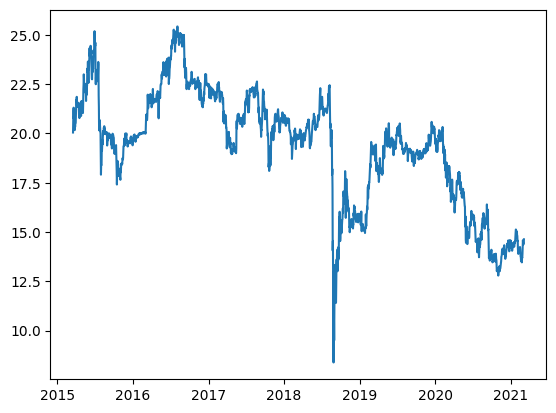

In [ ]:
plt.plot(df.index, df['Close'])

In [ ]:
def df_to_windowed_df(dataftrame, first_date_str, last_date_str, n=3):
  dataframe = df
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, '22-3-2015', '01-03-2021', n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2015-03-22,20.799999,21.150000,21.309999,20.760000
1,2015-03-23,21.150000,21.309999,20.760000,20.900000
2,2015-03-24,21.309999,20.760000,20.900000,21.049999
3,2015-03-25,20.760000,20.900000,21.049999,20.650000
4,2015-03-26,20.900000,21.049999,20.650000,20.170000
...,...,...,...,...,...
2167,2021-02-25,13.630000,13.460000,13.720000,13.690000
2168,2021-02-26,13.460000,13.720000,13.690000,13.900000
2169,2021-02-27,13.720000,13.690000,13.900000,14.340000
2170,2021-02-28,13.690000,13.900000,14.340000,14.580000


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2172,), (2172, 3, 1), (2172,))

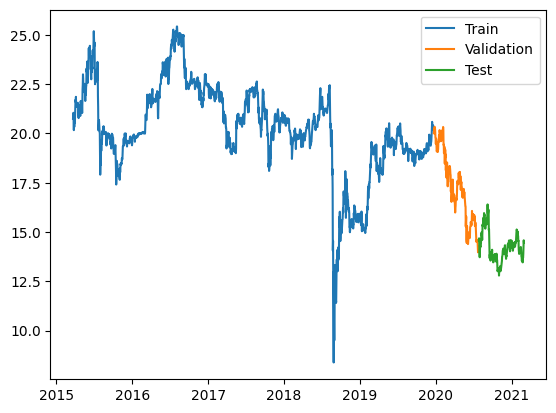

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
55/55 [==============================] - 6s 56ms/step - loss: 198.7195 - mean_absolute_error: 12.5320 - val_loss: 36.8715 - val_mean_absolute_error: 5.7559
Epoch 2/100
55/55 [==============================] - 1s 12ms/step - loss: 7.5908 - mean_absolute_error: 2.0631 - val_loss: 12.0669 - val_mean_absolute_error: 2.9940
Epoch 3/100
55/55 [==============================] - 1s 13ms/step - loss: 4.2207 - mean_absolute_error: 1.5104 - val_loss: 2.9991 - val_mean_absolute_error: 1.4514
Epoch 4/100
55/55 [==============================] - 1s 13ms/step - loss: 0.8963 - mean_absolute_error: 0.6240 - val_loss: 0.0928 - val_mean_absolute_error: 0.2372
Epoch 5/100
55/55 [==============================] - 1s 10ms/step - loss: 0.1507 - mean_absolute_error: 0.2568 - val_loss: 0.0969 - val_mean_absolute_error: 0.2344
Epoch 6/100
55/55 [==============================] - 1s 10ms/step - loss: 0.1329 - mean_absolute_error: 0.2395 - val_loss: 0.0789 - val_mean_absolute_error: 0.2100
Epoch 7/100

55/55 [==============================] - 1s 4ms/step


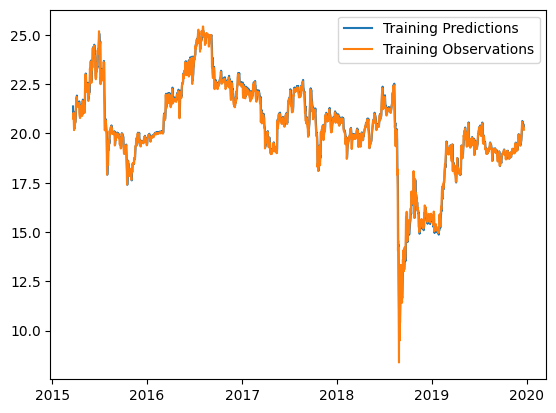

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 0s 4ms/step


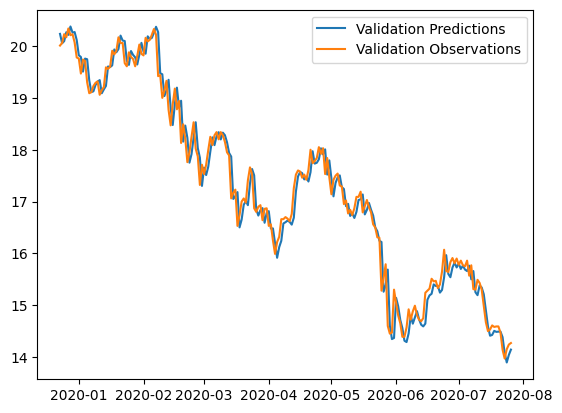

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 6ms/step


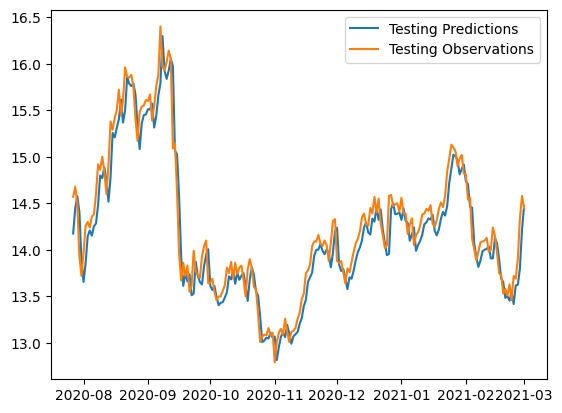

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

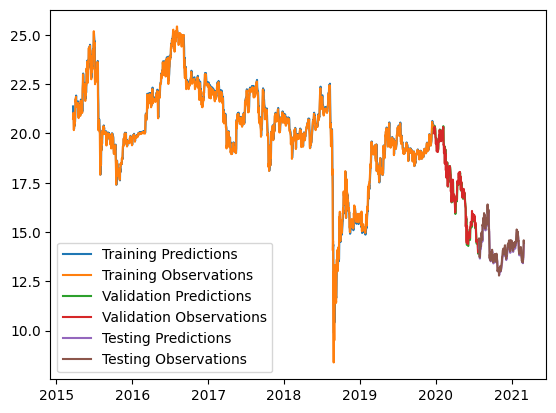

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 'Training Observations','Validation Predictions', 'Validation Observations', 'Testing Predictions', 'Testing Observations'])

In [ ]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 23ms/step


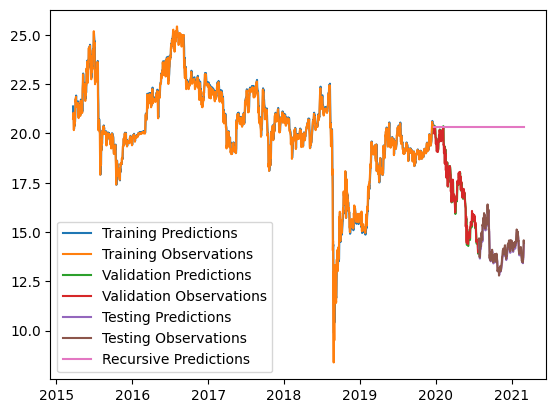

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])